# Part 3

In [11]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from scipy.interpolate import interp2d

try:  # if running with Google Colab
    from google.colab import drive
    drive.mount('/content/drive')

    import sys
    # the location where you saved the tools.py and csv files
    drive_dir = '/content/drive/My Drive/Colab Notebooks/FCTT 3'
    sys.path.insert(0, drive_dir)

    data_dir =os.path.join(drive_dir, 'battery_experimental_data')
except:  # if running locally
    data_dir = os.path.abspath('battery_experimental_data')
    
from tools import *

## Load data

In [2]:
training_data_20 = pd.read_csv(os.path.join(data_dir, 'Model_Training_Data_20.csv'))
SOC_OCV_data = pd.read_csv(os.path.join(data_dir, 'SOC_OCV_MFCTT_2019.csv'), sep='\t')

display(training_data_20.head())

,Time (s),Current (A),Voltage (V)
0,0.000000,0.0,4.2
1,1.000005,0.0,4.2
2,1.999999,0.0,4.2
3,3.000004,0.0,4.2
4,3.999998,0.0,4.2


In [3]:
# extract values in numpy array
ref_SOC = SOC_OCV_data['SOC'].values                   # unit in %
ref_OCV = SOC_OCV_data['Ecell/V'].values               # unit in V

t = training_data_20['Time (s)'].values                # unit in s
I = -training_data_20['Current (A)'].values             # unit in A
V_actual = training_data_20['Voltage (V)'].values      # unit in V

SOC_levels = np.arange(0.9, 0.1, -0.1)
SOC_from_idx_map = {i: SOC_levels[i] for i in range(8)}  # 8 SOC levels

## Model

### Constants

In [4]:
T0 = 20
R = 8.31446261815324        # Gas constant
m = 45.0e-3       # Cell mass 45.0 g

c = 825         # Specific heat
h = 10          # Heat transfer coefficient

# Cell Dimensions
height = 64.85e-3
radius = 18.33e-3 / 2

# Cell Surface Area
Area = 2*np.pi*radius*height + 2*np.pi*radius**2

### Thermal Model

In [5]:
def T_change(I, R0, R1, dt, T, T_env):
    dT = (I**2 * (R0 + R1) * dt - h*Area*(T - T_env)) / (m * c)
    T_new = T + dT
    return T_new

In [16]:
# Temperature depends R0
R0_const = 40e-3

def fit_R0_temp(T):
    R0_val = R0_const * np.exp(-E * (T^-1 - T0^-1) / R)
    return R0_val

In [14]:
# Temperature depends R1
R1_const = 40e-3
b = 1
c = 1

def fit_R1_temp(I, T):
    R1_val = R1_const * np.exp(-((I-b)**2) / (c)) * np.exp(-E * (T^-1 - T0^-1) / R)
    return R1_val

In [17]:
# Constant C1 :)
C1_const = 197.27991163742004

def fit_C1_temp(I, T):
    C1_val = C1_const
    return C1_val


In [19]:
T = None  # for now, no dependency on temperature
V_pred = first_order_ECN_temp(t_seg, I_seg, T, V_actual_seg, ref_OCV, ref_SOC,
                         fit_R0_temp, fit_R1_temp, fit_C1_temp)

NameError: name 'first_order_ECN_temp' is not defined

NameError: name 't_seg' is not defined

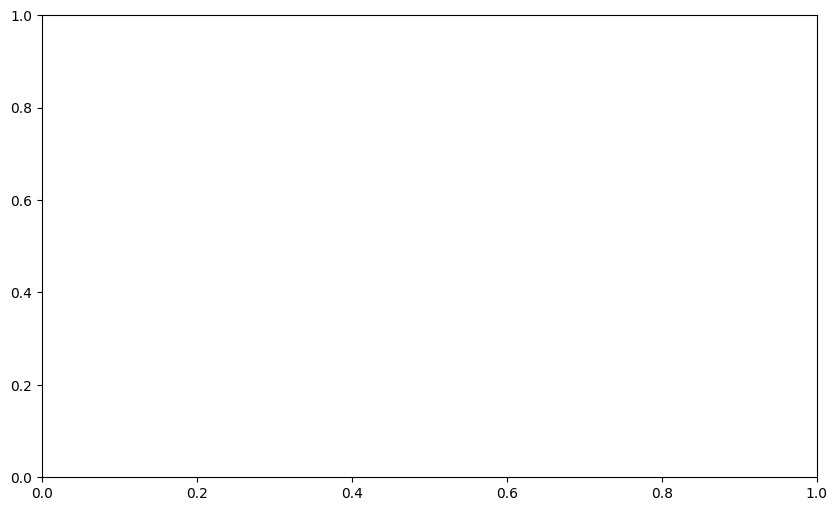

In [10]:
_, ax = plt.subplots(figsize=(10, 6))
ax.plot(t_seg, V_pred, label='First Order ECN Model Voltage')
ax.plot(t_seg, V_actual_seg, label='Actual Voltage')
ax.legend()
ax.set_xlim([t_seg[0], t_seg[-1]])
ax.set_xlabel('Time (s)')
ax.set_ylabel('Voltage (V)')
ax.set_title('First Order ECN Model Prediction')
plt.show()